In [1]:
symbol = "AMD"
shift = 5
confidence = .5

In [2]:
import yfinance as yf
import pandas as pd
from sklearn.metrics import precision_score
from sklearn.ensemble import HistGradientBoostingClassifier
from ta.trend import ema_indicator

In [3]:
stock = yf.Ticker(symbol)
#vix = yf.Ticker('^VIX').history('max')
#vix.index = pd.to_datetime(vix.index)
stock = stock.history(period = "max")
stock.index = pd.to_datetime(stock.index)
stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-03-17 00:00:00-05:00,0.000000,3.302083,3.125000,3.145833,219600,0.0,0.0
1980-03-18 00:00:00-05:00,0.000000,3.125000,2.937500,3.031250,727200,0.0,0.0
1980-03-19 00:00:00-05:00,0.000000,3.083333,3.020833,3.041667,295200,0.0,0.0
1980-03-20 00:00:00-05:00,0.000000,3.062500,3.010417,3.010417,159600,0.0,0.0
1980-03-21 00:00:00-05:00,0.000000,3.020833,2.906250,2.916667,130800,0.0,0.0
...,...,...,...,...,...,...,...
2024-04-23 00:00:00-04:00,151.649994,153.500000,150.350006,152.270004,46051900,0.0,0.0
2024-04-24 00:00:00-04:00,156.559998,157.660004,150.630005,151.740005,43412600,0.0,0.0
2024-04-25 00:00:00-04:00,149.149994,155.139999,146.750000,153.759995,41471400,0.0,0.0


<Axes: xlabel='Date'>

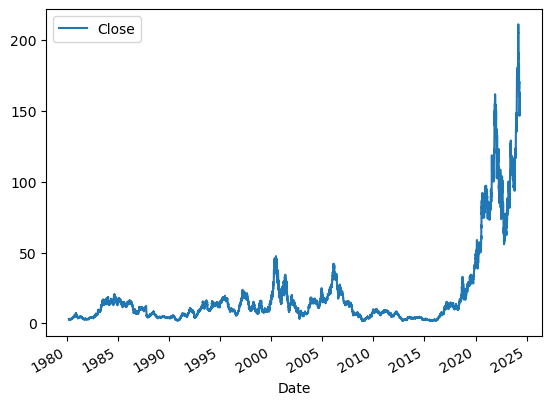

In [4]:
stock.plot.line(y="Close", use_index=True)

In [5]:
del stock['Dividends']
del stock['Stock Splits']

In [6]:
stock["Tomorrow"] = stock["Close"].shift(-shift)
stock["Target"] = (stock["Tomorrow"] > stock["Close"]).astype(int)
stock = stock.loc["2000-01-01":].copy()
#vix = vix.loc["2000-01-01":].copy()#.iloc[:-1]
#vix['Close'] = vix['Close'] * 3
#IV = pd.Series(vix['Close'])
#stock['IV'] = IV.tolist()
stock

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2000-01-03 00:00:00-05:00,14.968750,15.593750,14.687500,15.500000,7843200,17.5000,1
2000-01-04 00:00:00-05:00,15.125000,15.500000,14.593750,14.625000,6290200,17.2500,1
2000-01-05 00:00:00-05:00,14.531250,15.062500,14.000000,15.000000,8204600,18.1250,1
2000-01-06 00:00:00-05:00,15.500000,16.000000,15.250000,16.000000,11489400,18.8750,1
2000-01-07 00:00:00-05:00,15.406250,16.406250,15.375000,16.250000,8543400,20.1875,1
...,...,...,...,...,...,...,...
2024-04-23 00:00:00-04:00,151.649994,153.500000,150.350006,152.270004,46051900,NaN,0
2024-04-24 00:00:00-04:00,156.559998,157.660004,150.630005,151.740005,43412600,NaN,0
2024-04-25 00:00:00-04:00,149.149994,155.139999,146.750000,153.759995,41471400,NaN,0


In [7]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [8]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= confidence] = 1
    preds[preds < confidence] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [9]:
import warnings
warnings.filterwarnings("ignore")

horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = stock.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    stock[ratio_column] = stock["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    stock[trend_column] = stock.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]
    

stock['EMA_5'] = ema_indicator(stock.Close, window = 5).tolist()
stock['EMA_2'] = ema_indicator(stock.Close, window = 2).tolist()
stock['EMA_10'] = ema_indicator(stock.Close, window = 10).tolist()
stock['EMA_25'] = ema_indicator(stock.Close, window = 25).tolist()
new_predictors += ['EMA_5', 'EMA_2', 'EMA_10', 'EMA_25']

from ta.volatility import bollinger_hband, bollinger_lband, bollinger_mavg

stock['Bollinger High'] = bollinger_hband(stock.Close, window = 250).tolist()
stock['Bollinger Mid'] = bollinger_mavg(stock.Close, window = 250).tolist()
stock['Bollinger Low'] = bollinger_lband(stock.Close, window = 250).tolist()
new_predictors += ['Bollinger High', 'Bollinger Mid', 'Bollinger Low']

from ta.momentum import rsi

stock['RSI_1'] = rsi(stock.Close, window = 1).tolist()
stock['RSI_5'] = rsi(stock.Close, window = 5).tolist()
stock['RSI_25'] = rsi(stock.Close, window = 25).tolist()
new_predictors += ['RSI_1', 'RSI_5', 'RSI_25']

from ta.volume import force_index

stock['FI_1'] = force_index(stock.Close, stock.Volume, window = 1).tolist()
stock['FI_5'] = force_index(stock.Close, stock.Volume, window = 5).tolist()
stock['FI_25'] = force_index(stock.Close, stock.Volume, window = 25).tolist()
new_predictors += ['FI_1', 'FI_5', 'FI_25']

#new_predictors += ['IV']

new_predictors

['Close_Ratio_2',
 'Trend_2',
 'Close_Ratio_5',
 'Trend_5',
 'Close_Ratio_60',
 'Trend_60',
 'Close_Ratio_250',
 'Trend_250',
 'Close_Ratio_1000',
 'Trend_1000',
 'EMA_5',
 'EMA_2',
 'EMA_10',
 'EMA_25',
 'Bollinger High',
 'Bollinger Mid',
 'Bollinger Low',
 'RSI_1',
 'RSI_5',
 'RSI_25',
 'FI_1',
 'FI_5',
 'FI_25']

In [10]:
stock = stock.dropna(subset=stock.columns[stock.columns != "Tomorrow"])
stock.tail(11)

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,...,EMA_25,Bollinger High,Bollinger Mid,Bollinger Low,RSI_1,RSI_5,RSI_25,FI_1,FI_5,FI_25
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-15 00:00:00-04:00,164.429993,164.440002,158.759995,160.320007,61461200,148.639999,0,0.990853,0.0,0.963438,...,175.694204,193.213496,129.29260,65.371703,0.0,23.898174,42.262311,-1.819246e+08,-1.745654e+08,-9.606297e+07
2024-04-16 00:00:00-04:00,162.279999,164.880005,161.669998,163.460007,55302100,152.270004,0,1.009698,0.0,0.991027,...,174.753112,193.456187,129.58732,65.718452,100.0,36.502708,44.115054,1.736486e+08,-5.849407e+07,-7.531593e+07
2024-04-17 00:00:00-04:00,163.970001,164.449997,153.880005,154.020004,75909000,151.740005,0,0.970266,0.0,0.948890,...,173.158258,193.588209,129.84364,66.099070,0.0,22.498912,40.086701,-7.165811e+08,-2.778564e+08,-1.246440e+08
2024-04-18 00:00:00-04:00,155.509995,156.960007,152.320007,155.080002,52669800,153.759995,0,1.003429,0.0,0.973925,...,171.767623,193.727649,130.10352,66.479391,100.0,26.458897,40.719858,5.582986e+07,-1.666277e+08,-1.107614e+08
2024-04-19 00:00:00-04:00,151.589996,154.250000,145.289993,146.639999,71232500,157.399994,1,0.972027,0.0,0.940579,...,169.834729,193.774529,130.33636,66.898190,0.0,17.539293,37.438364,-6.012025e+08,-3.114859e+08,-1.484876e+08
2024-04-22 00:00:00-04:00,148.149994,149.889999,145.630005,148.639999,49397000,160.199997,1,1.006773,1.0,0.967910,...,168.204365,193.828245,130.58064,67.333034,100.0,25.025861,38.658577,9.879400e+07,-1.747260e+08,-1.294660e+08
2024-04-23 00:00:00-04:00,151.649994,153.500000,150.350006,152.270004,46051900,NaN,0,1.012063,2.0,1.006212,...,166.978645,193.882066,130.85452,67.826974,100.0,37.831307,40.840104,1.671686e+08,-6.076110e+07,-1.066479e+08
2024-04-24 00:00:00-04:00,156.559998,157.660004,150.630005,151.740005,43412600,NaN,0,0.998257,1.0,1.005740,...,165.806442,193.942052,131.11772,68.293388,0.0,36.687688,40.620395,-2.300863e+07,-4.817694e+07,-1.002141e+08
2024-04-25 00:00:00-04:00,149.149994,155.139999,146.750000,153.759995,41471400,NaN,0,1.006612,0.0,1.020915,...,164.879792,194.027186,131.38300,68.738813,100.0,44.657897,41.862112,8.377177e+07,-4.194036e+06,-8.606138e+07


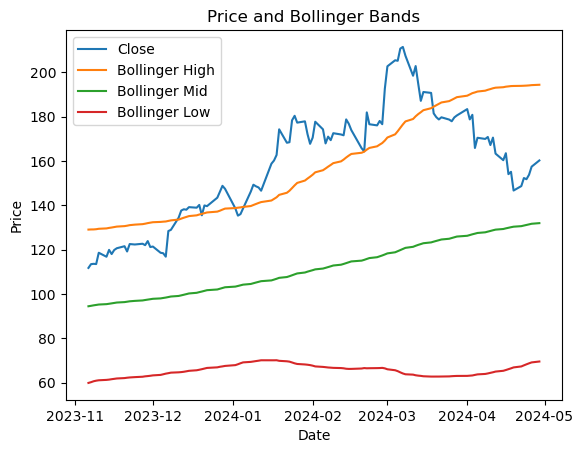

In [11]:
import matplotlib.pyplot as plt

x = 120

plt.plot(stock.index[-x:], stock.Close[-x:], label="Close")  # Plot line 1 with label
plt.plot(stock.index[-x:], stock['Bollinger High'][-x:], label="Bollinger High")  # Plot line 2 with label
plt.plot(stock.index[-x:], stock['Bollinger Mid'][-x:], label="Bollinger Mid")  # Plot line 3 with label
plt.plot(stock.index[-x:], stock['Bollinger Low'][-x:], label="Bollinger Low")  # Plot line 4 with label (added)

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price and Bollinger Bands")

# Add legend
plt.legend()

# Display the plot
plt.show()

In [12]:
model = HistGradientBoostingClassifier(random_state=1)

train = stock.iloc[:-100]
test = stock.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"] + new_predictors
model.fit(train[predictors], train["Target"])

HistGradientBoostingClassifier(random_state=1)

In [13]:
predictions = backtest(stock, model, predictors, start = 2500, step = 250)

In [14]:
predictions["Predictions"].value_counts()

Predictions
1.0    1411
0.0    1208
Name: count, dtype: int64

In [15]:
precision_score(predictions["Target"], predictions["Predictions"])

0.7526576895818569

In [16]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.543719
0    0.456281
Name: count, dtype: float64

In [17]:
def predict_recent(test, predictors, model):
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= confidence] = 1
    preds[preds < confidence] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined
recent_preds = predict_recent(test, predictors, model)


recent_preds.tail(10)                 

,Target,Predictions
Date,,
2024-04-16 00:00:00-04:00,0,0.0
2024-04-17 00:00:00-04:00,0,0.0
2024-04-18 00:00:00-04:00,0,0.0
2024-04-19 00:00:00-04:00,1,0.0
2024-04-22 00:00:00-04:00,1,1.0
2024-04-23 00:00:00-04:00,0,1.0
2024-04-24 00:00:00-04:00,0,0.0
2024-04-25 00:00:00-04:00,0,0.0
2024-04-26 00:00:00-04:00,0,0.0


In [18]:
if predictions.Predictions[-1] == 1:
    print("The model's most recent prediction is that", symbol, "will increase from the current close in the next", shift, "trading day(s).")
else:
    print("The model's most recent prediction is not at least", confidence*100, "% confident that", symbol, "will increase in the next", shift, "trading day(s).")
    
flag = False
for pred in predictions.Predictions[-shift:]:
    if pred == 1:
        flag = True
        break

if flag:
    print("\nIn the last", shift, "trading day(s), the model HAS predicted an increase in the price of", symbol, "with a confidence of at least", confidence*100, "%")
else:
    print("\nIn the last", shift, "trading day(s), the model HAS NOT predicted an increase in the price of", symbol, "with a confidence of at least", confidence*100, "%")

The model's most recent prediction is not at least 50.0 % confident that AMD will increase in the next 5 trading day(s).

In the last 5 trading day(s), the model HAS predicted an increase in the price of AMD with a confidence of at least 50.0 %


In [19]:
yf.Ticker("AMD").insider_transactions.head(10)

,Shares,Value,URL,Text,Insider,Position,Transaction,Start Date,Ownership
0,16200,2660850.0,,Sale at price 164.25 per share.,PAPERMASTER MARK D,Chief Technology Officer,,2024-04-15,D
1,16200,207846.0,,Conversion of Exercise of derivative security ...,PAPERMASTER MARK D,Chief Technology Officer,,2024-04-15,D
2,629,NaN,,,SMITH DARLA M,Officer,,2024-04-15,D
3,28840,NaN,,,PENG VICTOR,President,,2024-03-15,D
4,16200,3025082.0,,Sale at price 184.79 - 187.88 per share.,PAPERMASTER MARK D,Chief Technology Officer,,2024-03-15,D
5,16200,207846.0,,Conversion of Exercise of derivative security ...,PAPERMASTER MARK D,Chief Technology Officer,,2024-03-15,D
6,1934,NaN,,,SMITH DARLA M,Officer,,2024-03-15,D
7,1970,NaN,,,HUYNH JACK M,Officer,,2024-03-15,D
8,125000,24391404.0,,Sale at price 193.48 - 198.41 per share.,SU LISA T,Chief Executive Officer,,2024-03-13,D
9,32789,6961433.0,,Sale at price 212.31 per share.,WOLIN HARRY A,Officer,,2024-03-07,D


In [20]:
yf.Ticker("AMD").recommendations_summary

,period,strongBuy,buy,hold,sell,strongSell
0,0m,5,6,15,4,1
1,-1m,14,23,12,0,0
2,-2m,15,23,11,0,0
3,-3m,12,19,10,0,0
